In [27]:
import glob
import os
import os.path as osp
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

# ImageNet用のTransform
---

In [28]:
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

## file_pathを格納する関数

In [29]:
def make_datapath_list(rootpath='./data/', phase='train'):
    
    target_path = osp.join(rootpath, phase, '*/*')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list

# DataSetを作成
---

In [30]:
class KeyakiDatasest(data.Dataset):
    
    def __init__(self, file_list, label_list, transform=None, phase='train'):
        self.file_list = file_list
        self.label_list = label_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        
        img_path = self.file_list[index]
        img = Image.open(img_path).convert('RGB')
        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-2]
        label = label_list.index(label)
        
        return img_transformed, label

# Main学習
---

## DataLoaderの作成

In [34]:
# dataが存在するフォルダ(中身はtrain, valフォルダに分かれている前提）
rootpath = './keyaki_member_data_edited/'

# 学習するラベルのリスト．trainフォルダの中にあるフォルダ名から取得
label_list = os.listdir(rootpath + 'train')

# train, valのpathリスト
train_list = make_datapath_list(rootpath, 'train')
val_list = make_datapath_list(rootpath, 'valid')

# ImageNetの画像は以下のように前処理されている
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# トランスフォームインスタンスの生成
transform = ImageTransform(size, mean, std)

# train, valのdatasetを作成
train_dataset = KeyakiDatasest(train_list, label_list, transform=transform, phase='train')
val_dataset = KeyakiDatasest(val_list, label_list, transform=transform, phase='val')

# train, valのdataloaderを作成
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# train, valのdataloaderを辞書にまとめる
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

./keyaki_member_data_edited/train/*/*
./keyaki_member_data_edited/valid/*/*


## モデルの定義

In [35]:
# 学習済みの重みを使用するかどうか
use_pretrained = True
# mobilenetV2を使用
net = models.mobilenet_v2(pretrained=use_pretrained)

# 分類したいクラス数
out_features = 5
# 最終層だけ取り替える
net.classifier[1] = nn.Linear(in_features=1280, out_features=out_features)

# 学習モードへ移行
net.train()
for name, param in net.named_parameters():
    print(name)
print('ネットワーク設定完了：学習済みの重みをロードし，訓練モードに設定しました')

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.conv.0.0.weight
features.1.conv.0.1.weight
features.1.conv.0.1.bias
features.1.conv.1.weight
features.1.conv.2.weight
features.1.conv.2.bias
features.2.conv.0.0.weight
features.2.conv.0.1.weight
features.2.conv.0.1.bias
features.2.conv.1.0.weight
features.2.conv.1.1.weight
features.2.conv.1.1.bias
features.2.conv.2.weight
features.2.conv.3.weight
features.2.conv.3.bias
features.3.conv.0.0.weight
features.3.conv.0.1.weight
features.3.conv.0.1.bias
features.3.conv.1.0.weight
features.3.conv.1.1.weight
features.3.conv.1.1.bias
features.3.conv.2.weight
features.3.conv.3.weight
features.3.conv.3.bias
features.4.conv.0.0.weight
features.4.conv.0.1.weight
features.4.conv.0.1.bias
features.4.conv.1.0.weight
features.4.conv.1.1.weight
features.4.conv.1.1.bias
features.4.conv.2.weight
features.4.conv.3.weight
features.4.conv.3.bias
features.5.conv.0.0.weight
features.5.conv.0.1.weight
features.5.conv.0.1.bias
features.5.conv.1.

## 損失関数の定義

In [36]:
criterion = nn.CrossEntropyLoss()

## 最適化手法の決定

In [38]:
params_to_update = []

def get_param_name(n):
    '''
    classifierの重み，バイアス名を取得する関数
    '''
    return ['classifier.%d.weight' %n, 'classifier.%d.bias' %n]

update_params_name = get_param_name(1)

for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print('params_to_updateに格納:', name)
    else:
        param.requires_grad = False
        print('勾配計算なし．学習しない:', name)

勾配計算なし．学習しない: features.0.0.weight
勾配計算なし．学習しない: features.0.1.weight
勾配計算なし．学習しない: features.0.1.bias
勾配計算なし．学習しない: features.1.conv.0.0.weight
勾配計算なし．学習しない: features.1.conv.0.1.weight
勾配計算なし．学習しない: features.1.conv.0.1.bias
勾配計算なし．学習しない: features.1.conv.1.weight
勾配計算なし．学習しない: features.1.conv.2.weight
勾配計算なし．学習しない: features.1.conv.2.bias
勾配計算なし．学習しない: features.2.conv.0.0.weight
勾配計算なし．学習しない: features.2.conv.0.1.weight
勾配計算なし．学習しない: features.2.conv.0.1.bias
勾配計算なし．学習しない: features.2.conv.1.0.weight
勾配計算なし．学習しない: features.2.conv.1.1.weight
勾配計算なし．学習しない: features.2.conv.1.1.bias
勾配計算なし．学習しない: features.2.conv.2.weight
勾配計算なし．学習しない: features.2.conv.3.weight
勾配計算なし．学習しない: features.2.conv.3.bias
勾配計算なし．学習しない: features.3.conv.0.0.weight
勾配計算なし．学習しない: features.3.conv.0.1.weight
勾配計算なし．学習しない: features.3.conv.0.1.bias
勾配計算なし．学習しない: features.3.conv.1.0.weight
勾配計算なし．学習しない: features.3.conv.1.1.weight
勾配計算なし．学習しない: features.3.conv.1.1.bias
勾配計算なし．学習しない: features.3.conv.2.weight
勾配計算なし．学習しない: features.3.c

In [42]:
optimizer = optim.SGD(params=params_to_update, lr=1e-3, momentum=0.9)

## 学習，検証を実施

In [47]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('使用デバイス:', device)
    
    net.to(device)
    
    torch.backends.cudnn.benchmark = True
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        print('Epoch %d/%d' %(epoch+1, num_epochs))
        print('---------')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            if epoch == 0 and phase == 'train':
                continue
            
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            if epoch != 0:
                if phase == 'train':
                    train_losses.append(float(epoch_loss))
                    train_accuracies.append(float(epoch_acc))
                elif phase == 'val':
                    val_losses.append(float(epoch_loss))
                    val_accuracies.append(float(epoch_acc))

            print('%s Loss: %.4f Acc: %.4f' %(phase, epoch_loss, epoch_acc))
    return train_losses, val_losses, train_accuracies, val_accuracies

In [50]:
num_epochs = 2
train_losses, val_losses, train_accuracies, val_accuracies = train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)


  0%|          | 0/3 [00:00<?, ?it/s]

使用デバイス: cpu
Epoch 1/2
---------



100%|██████████| 3/3 [00:41<00:00, 13.94s/it]

  0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 1.5452 Acc: 0.3043
Epoch 2/2
---------



100%|██████████| 13/13 [04:21<00:00, 20.09s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 1.5482 Acc: 0.2793



100%|██████████| 3/3 [00:37<00:00, 12.57s/it]

val Loss: 1.4850 Acc: 0.3913


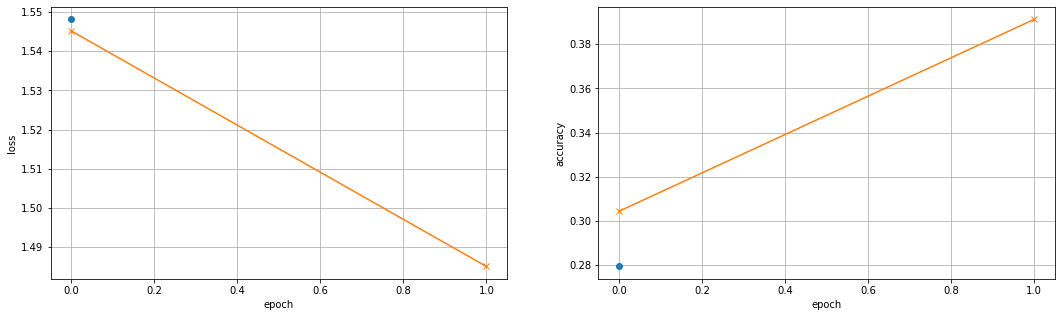

In [70]:
fig = plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.plot(val_losses, marker='x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o')
plt.plot(val_accuracies, marker='x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)


## 学習したモデルを保存

In [ ]:
save_path = './weights_keyaki_fine_tuning.pth'
torch.save(net.state_dict(), save_path)